In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_csv("data_2.csv")

In [9]:
df.columns.tolist()

['Unnamed: 0',
 'Country Name',
 'Country Code',
 'Year',
 'Control of Corruption: Percentile Rank',
 'GDP growth (annual %)',
 'Gini index',
 'Net official development assistance received (constant 2021 US$)',
 'Political Stability and Absence of Violence/Terrorism: Percentile Rank',
 'Population, total',
 'Poverty headcount ratio at societal poverty line (% of population)']

In [10]:
df = df.drop(columns=['Unnamed: 0'])

In [11]:
# Sort data by country and year for lagging
df = df.sort_values(['Country Code', 'Year'])

# Create 1-year lagged features for economic indicators
lag_years = 1
features_to_lag = [
    'Control of Corruption: Percentile Rank',
    'GDP growth (annual %)',
    'Gini index',
    'Political Stability and Absence of Violence/Terrorism: Percentile Rank',
    'Population, total',
    'Poverty headcount ratio at societal poverty line (% of population)'
]

for col in features_to_lag:
    df[f'{col}_lag{lag_years}'] = df.groupby('Country Code')[col].shift(lag_years)

# Drop original features
df = df.drop(columns=features_to_lag)

# Separate features from target
y = np.arcsinh(df['Net official development assistance received (constant 2021 US$)'])
X = df.drop(columns=['Net official development assistance received (constant 2021 US$)', 'Country Name', 'Country Code', 'Year']).copy()

# Handle missing values with dummies and zero imputation
missing_cols = X.columns[X.isnull().any()]
for col in missing_cols:
    X[f'{col}_missing'] = X[col].isnull().astype(int)
    X[col] = X[col].fillna(0)  # Proper in-place replacement

# Time-based split (using original year column)
sorted_years = sorted(df['Year'].unique())
cutoff = sorted_years[int(0.8 * len(sorted_years))]
train_mask = df['Year'] <= cutoff
test_mask = df['Year'] > cutoff

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

# MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Time-series cross-validated Lasso
tscv = TimeSeriesSplit(n_splits=5)
lasso = Lasso(max_iter=10000)
param_grid = {'alpha': np.logspace(0, .1, 10)}

# Grid search 
grid_search = GridSearchCV(lasso, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# evaluating best model
best_lasso = grid_search.best_estimator_
train_pred = best_lasso.predict(X_train_scaled)
test_pred = best_lasso.predict(X_test_scaled)

print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")

print(f"Train R^2: {best_lasso.score(X_train_scaled, y_train):.4f}")
print(f"Test R^2: {best_lasso.score(X_test_scaled, y_test):.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop Predictive Features:")
print(feature_importance[feature_importance['Coefficient'] != 0])

Best alpha: 1.22712523985119
Train RMSE: 5.6354
Test RMSE: 5.1929
Train R^2: 0.0000
Test R^2: -0.0079

Top Predictive Features:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []


Computing regularization path...


/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.269844928254315, tolerance: 52.51068761749126
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.479397460214386, tolerance: 52.51068761749126
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.72010366949

(np.float64(2.460109222210175e-09),
 np.float64(41.88778389258154),
 np.float64(-106.90856939762666),
 np.float64(103.54335975760092))

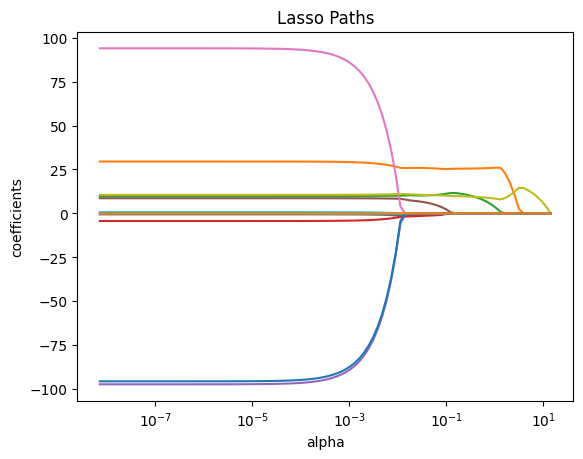

In [15]:
from sklearn.linear_model import lasso_path
from matplotlib import pyplot as plt

eps = 5e-10

print("Computing regularization path...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, eps=eps)

for coef in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")